# YOLOv8 Training on People Detection Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install ultralytics roboflow opencv-python matplotlib
!pip install torch torchvision



Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 134.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [3]:
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from collections import Counter
import random
from PIL import Image, ImageDraw
import ultralytics
from pathlib import Path


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Download and prepare dataset

The dataset is in Pascal VOC format, and needs to be converted to YOLO format.

In [4]:
# Downloading and unzipping the dataset
!mkdir -p /content/datasets
!mkdir -p /content/datasets/people_detection

!curl -L -o /content/datasets/people_detection.zip https://www.kaggle.com/api/v1/datasets/download/adilshamim8/people-detection

!unzip -q /content/datasets/people_detection -d /content/datasets/people_detection/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1990M  100 1990M    0     0   171M      0  0:00:11  0:00:11 --:--:--  168M


## View the annotations

Training Dataset Annotations

In [5]:
df = pd.read_csv("/content/datasets/people_detection/train/train/_annotations.csv")
df.head()

filename  width  height   class  \
0  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
1  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
2  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
3  004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333  person   
4  004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333  person   

   xmin  ymin  xmax  ymax  
0   219    98   269   283  
1   114   124   155   263  
2    43   139    98   340  
3   145   118   229   333  
4   285   105   349   329

Test Dataset Annotations

In [6]:

df = pd.read_csv("/content/datasets/people_detection/test/test/_annotations.csv")
df.head()



filename  width  height   class  \
0  0002640_jpg.rf.a1f2d386da1e4821651f9dec0cf5254...   1280     964  person   
1  2007_006841_jpg.rf.cdc00183ebc2771e932eb4f907e...    500     316  person   
2  2007_006841_jpg.rf.cdc00183ebc2771e932eb4f907e...    500     316  person   
3  2008_002523_jpg.rf.0504a335ef96ee9f9ac5153b237...    500     375  person   
4  2007_004065_jpg.rf.99a8c0f81203b9368f6938238b1...    500     375  person   

   xmin  ymin  xmax  ymax  
0   165   511   217   642  
1   385   105   435   283  
2   488   117   499   215  
3   232    10   369   180  
4   451   187   474   244

Validation Dataset Annotations

In [7]:
df = pd.read_csv("/content/datasets/people_detection/valid/valid/_annotations.csv")
df.head()

filename  width  height   class  \
0  BSMT1XOO121P_jpg.rf.3172b37162bba43942f1a82395...    500     375  person   
1  point03_140_png_jpg.rf.4166a3ba6f32cf3fad662d2...   1280     720  person   
2  point03_140_png_jpg.rf.4166a3ba6f32cf3fad662d2...   1280     720  person   
3  point01_179_png_jpg.rf.4b397a9403192a0c286c5f3...   1280     720  person   
4  2010_003325_jpg.rf.9caa17b2dd1dade077477d4ae80...    500     375  person   

   xmin  ymin  xmax  ymax  
0   254   136   350   304  
1   406   138   609   488  
2   681     0   711   101  
3   836   244   976   579  
4   213    40   476   316

## Reorganise dataset to YOLO format

In [8]:
def create_yolo_dataset_from_csv(csv_paths, image_dirs, output_base_dir):
    """
    Convert CSV dataset to YOLO format
    """
    output_base = Path(output_base_dir)
    output_base.mkdir(exist_ok=True)

    for split in ['train', 'val', 'test']:
        # Read CSV
        df = pd.read_csv(csv_paths[split])

        # Create directories
        img_dir = output_base / split / 'images'
        label_dir = output_base / split / 'labels'
        img_dir.mkdir(parents=True, exist_ok=True)
        label_dir.mkdir(parents=True, exist_ok=True)

        # Process each image
        for img_name, row in df.groupby('filename').first().iterrows():
            src_img = Path(image_dirs[split]) / img_name

            if src_img.exists():
                # Copy image
                shutil.copy(src_img, img_dir / img_name)

                # Create YOLO annotation
                img_annotations = df[df['filename'] == img_name]
                txt_path = label_dir / f"{Path(img_name).stem}.txt"

                with open(txt_path, 'w') as f:
                    for _, ann in img_annotations.iterrows():
                        # Convert to YOLO format
                        x_center = (ann['xmin'] + ann['xmax']) / 2 / ann['width']
                        y_center = (ann['ymin'] + ann['ymax']) / 2 / ann['height']
                        width = (ann['xmax'] - ann['xmin']) / ann['width']
                        height = (ann['ymax'] - ann['ymin']) / ann['height']

                        f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Processed {split}: {len(os.listdir(img_dir))} images")

    # Create data.yaml
    yaml_content = f"""path: {output_base}
train: train/images
val: val/images
test: test/images

nc: 1  # number of classes
names: ['face']  # changed from 'person' to 'face'

# Dataset statistics
# train: {len(os.listdir(output_base / 'train' / 'images'))} images
# val: {len(os.listdir(output_base / 'val' / 'images'))} images
# test: {len(os.listdir(output_base / 'test' / 'images'))} images
"""

    with open(output_base / 'data.yaml', 'w') as f:
        f.write(yaml_content)

    return output_base

In [9]:
csv_paths = {
    'train': '/content/datasets/people_detection/train/train/_annotations.csv',
    'val': '/content/datasets/people_detection/valid/valid/_annotations.csv',
    'test': '/content/datasets/people_detection/test/test/_annotations.csv'
}

image_dirs = {
    'train': '/content/datasets/people_detection/train/train',
    'val': '/content/datasets/people_detection/valid/valid',
    'test': '/content/datasets/people_detection/test/test'
}

output_base_dir = '/content/datasets/people_detection_yolo'

# Run the conversion
yolo_dataset_path = create_yolo_dataset_from_csv(csv_paths, image_dirs, output_base_dir)
print(f"YOLO dataset created at: {yolo_dataset_path}")

Processed train: 13278 images
Processed val: 1370 images
Processed test: 738 images
YOLO dataset created at: /content/datasets/people_detection_yolo


## Check dataset

Training annotations: 100082
Test annotations: 2783
Validation annotations: 10683

Training images: 15210
Test images: 760
Validation images: 1431
First training image:


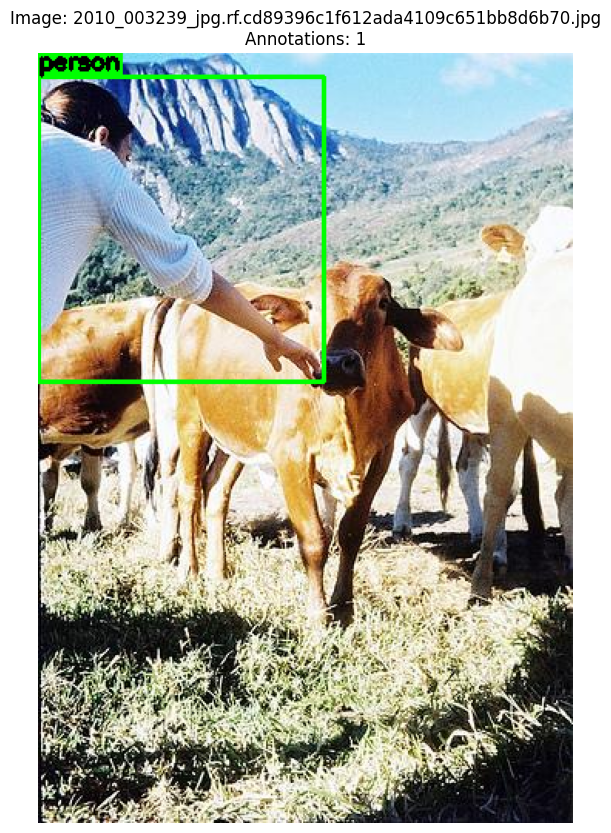

Image: 2010_003239_jpg.rf.cd89396c1f612ada4109c651bb8d6b70.jpg
Dimensions: 347x500
Number of people detected: 1

Bounding boxes:
  Person: [0, 15, 185, 213]
--------------------------------------------------

Random training samples:

Sample 1/3:


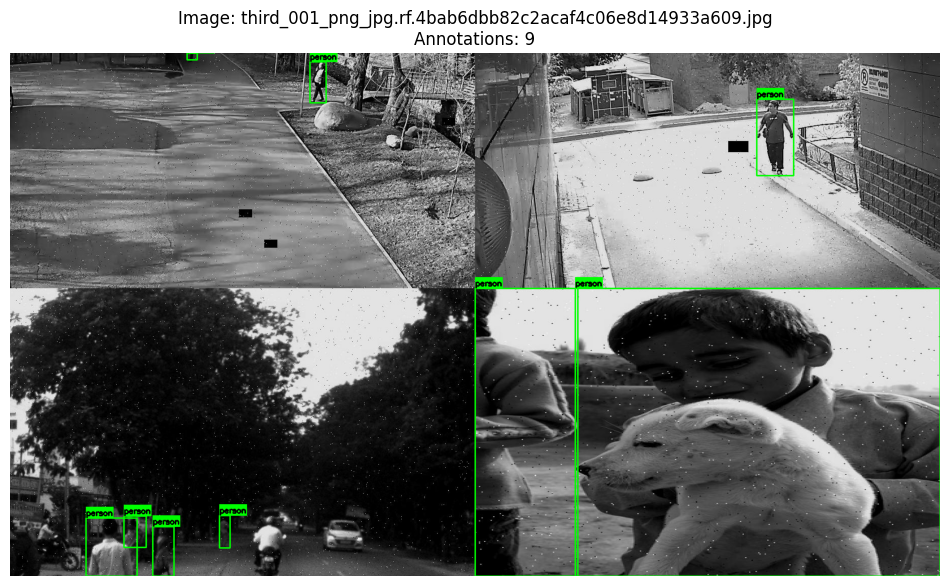

Image: third_001_png_jpg.rf.4bab6dbb82c2acaf4c06e8d14933a609.jpg
Dimensions: 1840x1034
Number of people detected: 9

Bounding boxes:
  Person: [593, 17, 625, 98]
  Person: [350, 0, 370, 13]
  Person: [1477, 91, 1550, 242]
  Person: [150, 919, 251, 1034]
  Person: [225, 915, 269, 977]
  Person: [282, 936, 324, 1034]
  Person: [414, 914, 435, 978]
  Person: [1118, 465, 1840, 1034]
  Person: [920, 465, 1123, 1034]
--------------------------------------------------

Sample 2/3:


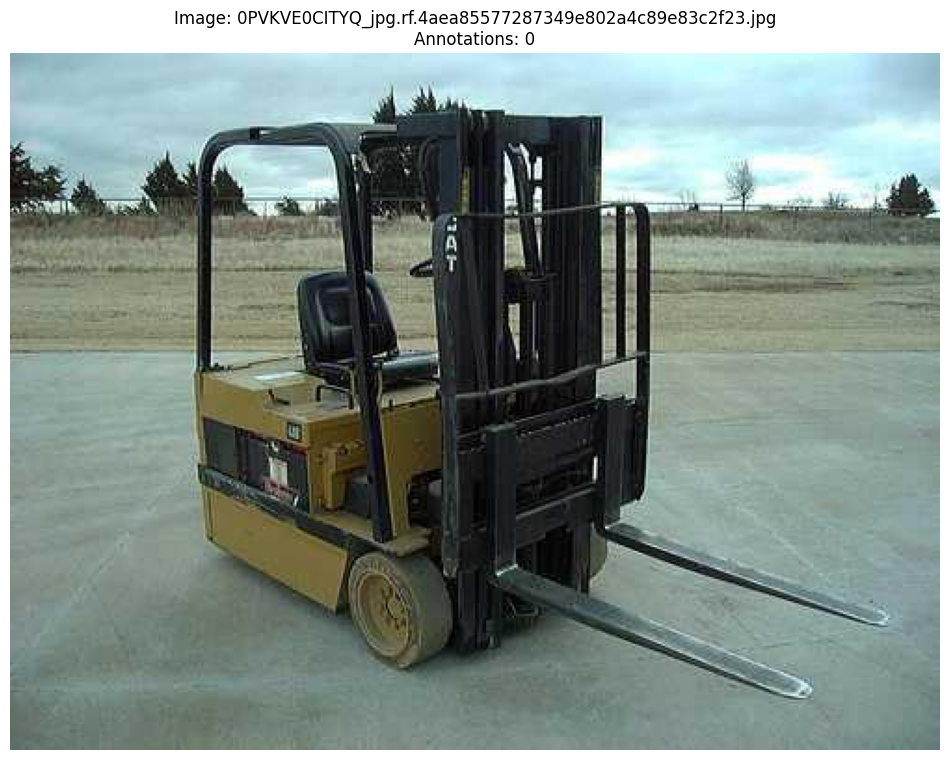

Image: 0PVKVE0CITYQ_jpg.rf.4aea85577287349e802a4c89e83c2f23.jpg
Dimensions: 500x375
Number of people detected: 0
--------------------------------------------------

Sample 3/3:


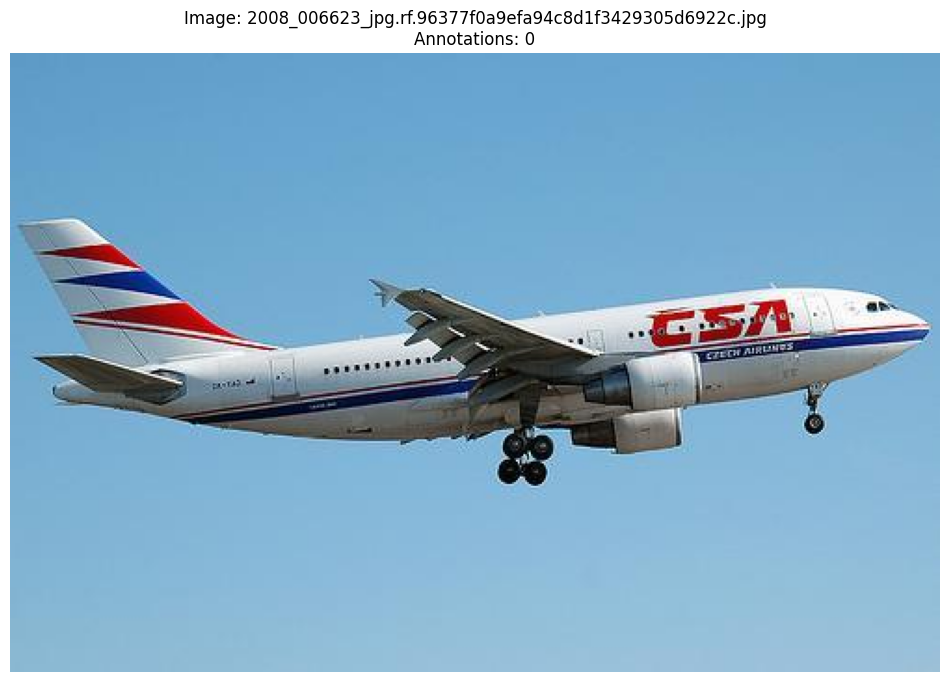

Image: 2008_006623_jpg.rf.96377f0a9efa94c8d1f3429305d6922c.jpg
Dimensions: 500x333
Number of people detected: 0
--------------------------------------------------


In [10]:
import glob

train_labels = pd.read_csv("/content/datasets/people_detection/train/train/_annotations.csv")
test_labels = pd.read_csv("/content/datasets/people_detection/test/test/_annotations.csv")
val_labels = pd.read_csv("/content/datasets/people_detection/valid/valid/_annotations.csv")

print(f"Training annotations: {len(train_labels)}")
print(f"Test annotations: {len(test_labels)}")
print(f"Validation annotations: {len(val_labels)}")

train_images = glob.glob('/content/datasets/people_detection/train/train/*.jpg')
test_images = glob.glob('/content/datasets/people_detection/test/test/*.jpg')
val_images = glob.glob('/content/datasets/people_detection/valid/valid/*.jpg')

print(f"\nTraining images: {len(train_images)}")
print(f"Test images: {len(test_images)}")
print(f"Validation images: {len(val_images)}")


# Display sample image with annotations from CSV
def show_sample(image_path, labels_df):
    """
    Display image with bounding boxes from CSV annotations

    Args:
        image_path: Path to the image file
        labels_df: DataFrame containing annotations for all images
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load image: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get filename from path
    filename = os.path.basename(image_path)

    # Filter annotations for this specific image
    img_annotations = labels_df[labels_df['filename'] == filename]

    if not img_annotations.empty:
        for _, row in img_annotations.iterrows():
            # Get bounding box coordinates from CSV
            x1 = int(row['xmin'])
            y1 = int(row['ymin'])
            x2 = int(row['xmax'])
            y2 = int(row['ymax'])
            class_name = row['class']

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add label text
            label = f"{class_name}"
            # Get text size for background rectangle
            (text_width, text_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2
            )

            # Draw background rectangle for text
            cv2.rectangle(
                img,
                (x1, y1 - text_height - 10),
                (x1 + text_width, y1),
                (0, 255, 0),
                -1  # Filled rectangle
            )

            # Add text
            cv2.putText(
                img,
                label,
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 0),  # Black text
                2
            )

    # Display image
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')

    # Add title with annotation count
    num_annotations = len(img_annotations)
    plt.title(f"Image: {filename}\nAnnotations: {num_annotations}")
    plt.show()

    # Print annotation details
    print(f"Image: {filename}")
    print(f"Dimensions: {img.shape[1]}x{img.shape[0]}")
    print(f"Number of people detected: {num_annotations}")

    if not img_annotations.empty:
        print("\nBounding boxes:")
        for _, row in img_annotations.iterrows():
            print(f"  Person: [{row['xmin']}, {row['ymin']}, {row['xmax']}, {row['ymax']}]")

    print("-" * 50)

# Display multiple samples
def show_multiple_samples(image_paths, labels_df, num_samples=3):
    """Display multiple sample images"""
    import random

    if len(image_paths) < num_samples:
        num_samples = len(image_paths)

    sampled_paths = random.sample(image_paths, num_samples)

    for i, img_path in enumerate(sampled_paths, 1):
        print(f"\nSample {i}/{num_samples}:")
        show_sample(img_path, labels_df)

# Display a sample from training set
if train_images:
    img_path = train_images[0]
    print("First training image:")
    show_sample(img_path, train_labels)

# Display random samples
print("\nRandom training samples:")
show_multiple_samples(train_images, train_labels, num_samples=3)


# Train YOLO8 model

In [ ]:
# GPU Verification & L4 Optimization
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Using device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.2f} GB")

    # Enable L4 optimizations
    if 'L4' in gpu_name:
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    else:
        torch.backends.cudnn.benchmark = True
        print(f"GPU: {gpu_name}")

    torch.cuda.empty_cache()
else:
    print("WARNING: CUDA not available")

# Automatic Checkpoint Resume
last_checkpoint = '/content/results/face_detection_l4/weights/last.pt'
resume_training = os.path.exists(last_checkpoint)

if resume_training:
    print(f"Resuming from: {last_checkpoint}")
    model = YOLO(last_checkpoint)
else:
    print("Starting fresh with YOLOv8n")
    model = YOLO('yolov8n.pt')

# L4-Optimized Training Configuration
train_args = {
    # Data & Duration
    'data': '/content/datasets/people_detection_yolo/data.yaml',
    'epochs': 100,

    # L4 Performance Settings
    'imgsz': 640,
    'batch': 48,
    'workers': 6,
    'device': device,
    'amp': True,
    'cache': 'ram',

    # Checkpointing
    'save': True,
    'save_period': 8, # Save after 8 epochs
    'project': '/content/results',
    'name': 'face_detection_l4',
    'exist_ok': True,
    'resume': resume_training,

    # Optimization
    'optimizer': 'AdamW',
    'lr0': 0.0012, # Slightly higher for larger batch
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3.0,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,

    # Loss Weights
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,

    # Face-Optimized Augmentation
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 10.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1,
    'copy_paste': 0.0,

    # Monitoring
    'val': True,
    'plots': True,
    'patience': 30,
    'verbose': True,

    # Advanced
    'pretrained': True,
    'freeze': None,
    'seed': 42,
    'deterministic': True,
    'single_cls': True,
    'cos_lr': True,
    'close_mosaic': 10,
}


print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Model:          YOLOv8n")
print(f"Dataset:        15,210 images")
print(f"Batch Size:     {train_args['batch']}")
print(f"Epochs:         {train_args['epochs']}")
print(f"Workers:        {train_args['workers']}")
print(f"\nExpected:")
print(f"  • Time:       100-150 minutes (~2 hours)")
print(f"  • Speed:      60-80 images/sec")
print(f"  • Cost:       ~$1.00")
print(f"  • Speedup:    1.5-2x faster than T4")
print("="*60 + "\n")


try:
    results = model.train(**train_args)
    print("\nTraining completed!")

    import pandas as pd
    df = pd.read_csv('/content/results/face_detection_l4/results.csv')
    df.columns = df.columns.str.strip()
    best_epoch = df['metrics/mAP50-95(B)'].idxmax()

    print("\nBest Results:")
    print(f"  Epoch: {best_epoch + 1}")
    print(f"  mAP@0.5: {df.loc[best_epoch, 'metrics/mAP50(B)']:.4f}")
    print(f"  mAP@0.5:0.95: {df.loc[best_epoch, 'metrics/mAP50-95(B)']:.4f}")
    print(f"\nModel: /content/results/face_detection_l4/weights/best.pt")

except KeyboardInterrupt:
    print("\nTraining interrupted - will resume next run")
except Exception as e:
    print(f"\nError: {e}")
    raise

✓ Using device: cuda
GPU: NVIDIA L4
GPU Memory: 22.16 GB
Starting fresh with YOLOv8n


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)



TRAINING CONFIGURATION
Model:          YOLOv8n
Dataset:        15,210 images
Batch Size:     48
Epochs:         100
Workers:        6

Expected:
  • Time:       100-150 minutes (~2 hours)
  • Speed:      60-80 images/sec
  • Cost:       ~$1.00
  • Speedup:    1.5-2x faster than T4

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=48, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/datasets/people_detection_yolo/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj

In [14]:
!cp -r /content/results/face_detection_l4 /content/drive/MyDrive/


## Start training

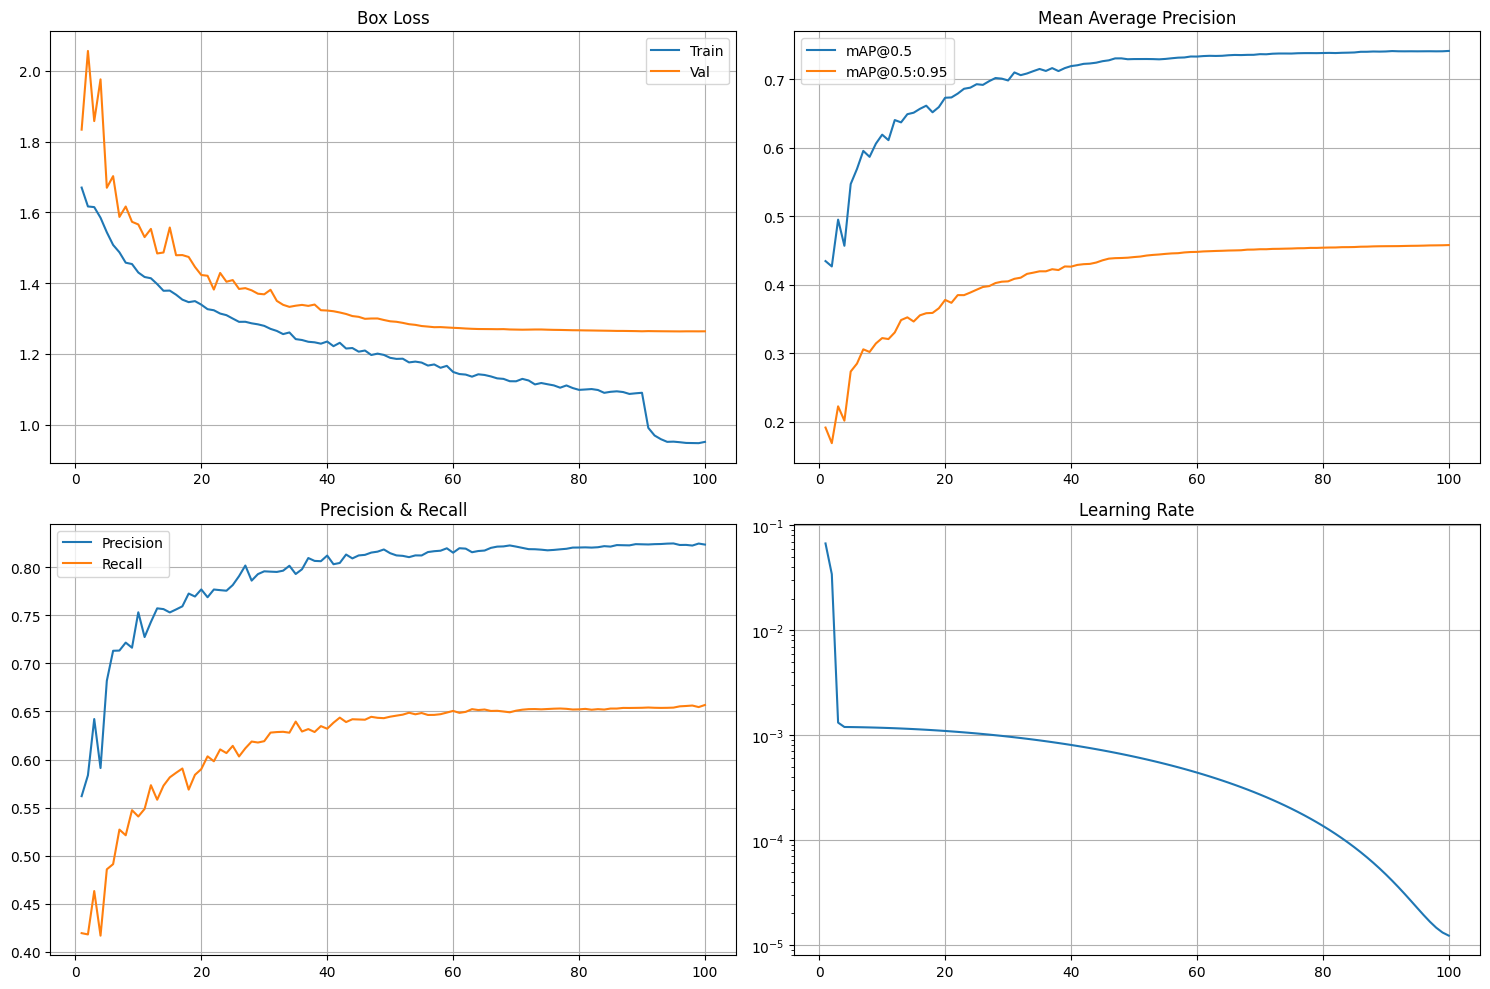

\nBest epoch: 100
mAP@0.5: 0.7417
mAP@0.5:0.95: 0.4583


In [15]:
df = pd.read_csv('/content/results/face_detection_l4/results.csv')
df.columns = df.columns.str.strip()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train')
axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val')
axes[0, 0].set_title('Box Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# mAP curves
axes[0, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
axes[0, 1].set_title('Mean Average Precision')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision & Recall
axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
axes[1, 0].set_title('Precision & Recall')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning Rate
axes[1, 1].plot(df['epoch'], df['lr/pg0'])
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Summary
best_epoch = df['metrics/mAP50-95(B)'].idxmax()
print(f"\\nBest epoch: {best_epoch + 1}")
print(f"mAP@0.5: {df.loc[best_epoch, 'metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {df.loc[best_epoch, 'metrics/mAP50-95(B)']:.4f}")

# Test inference


=== Training Results Summary ===
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
95     96  9000.75         0.95020         0.66647         1.04004   
96     97  9089.08         0.94818         0.66499         1.03952   
97     98  9177.56         0.94783         0.66549         1.03734   
98     99  9266.04         0.94751         0.66367         1.03939   
99    100  9354.49         0.95114         0.66711         1.03897   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
95               0.82313            0.65535           0.74117   
96               0.82322            0.65572           0.74122   
97               0.82254            0.65619           0.74111   
98               0.82462            0.65458           0.74119   
99               0.82355            0.65677           0.74167   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
95              0.45746       1.26348       0.77654       1.15389  0.000019

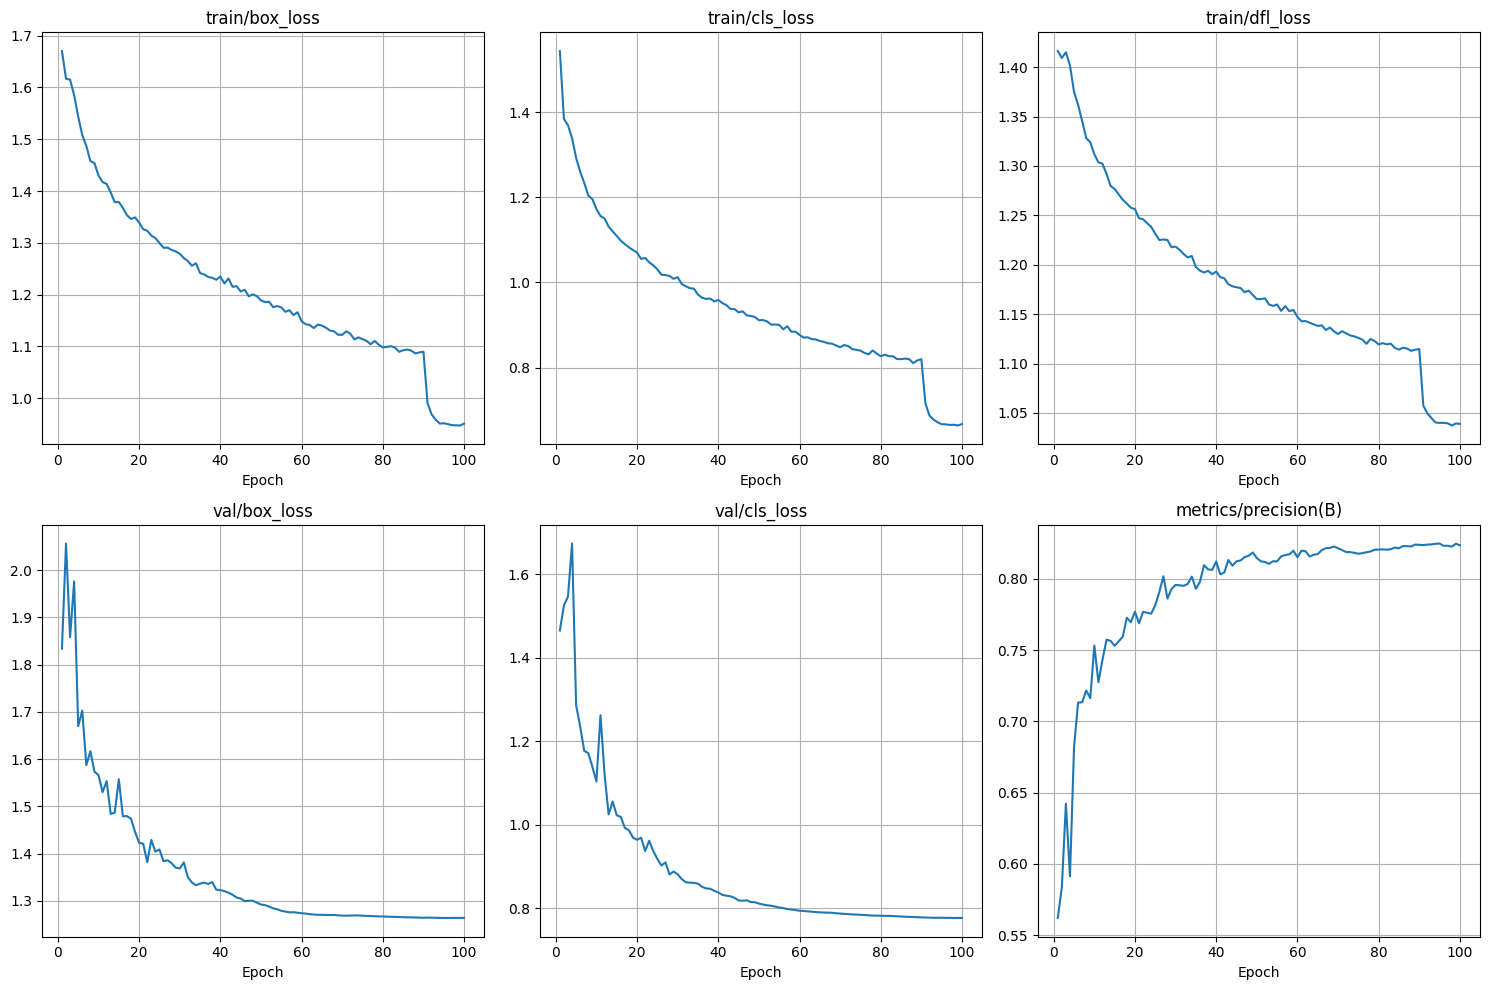


=== Validation Metrics ===
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1624.3±907.7 MB/s, size: 120.9 KB)
val: Scanning /content/datasets/people_detection_yolo/val/labels.cache... 1370 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1370/1370 2.0Mit/s 0.0s
val: /content/datasets/people_detection_yolo/val/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 86/86 9.1it/s 9.5s
                   all       1370      10660      0.813      0.677      0.751       0.46
Speed: 0.6ms preprocess, 1.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Saving /content/runs/detect/val6/predictions.json...
Results saved to /content/runs/detect/val6
mAP50-95: 0.4602
m

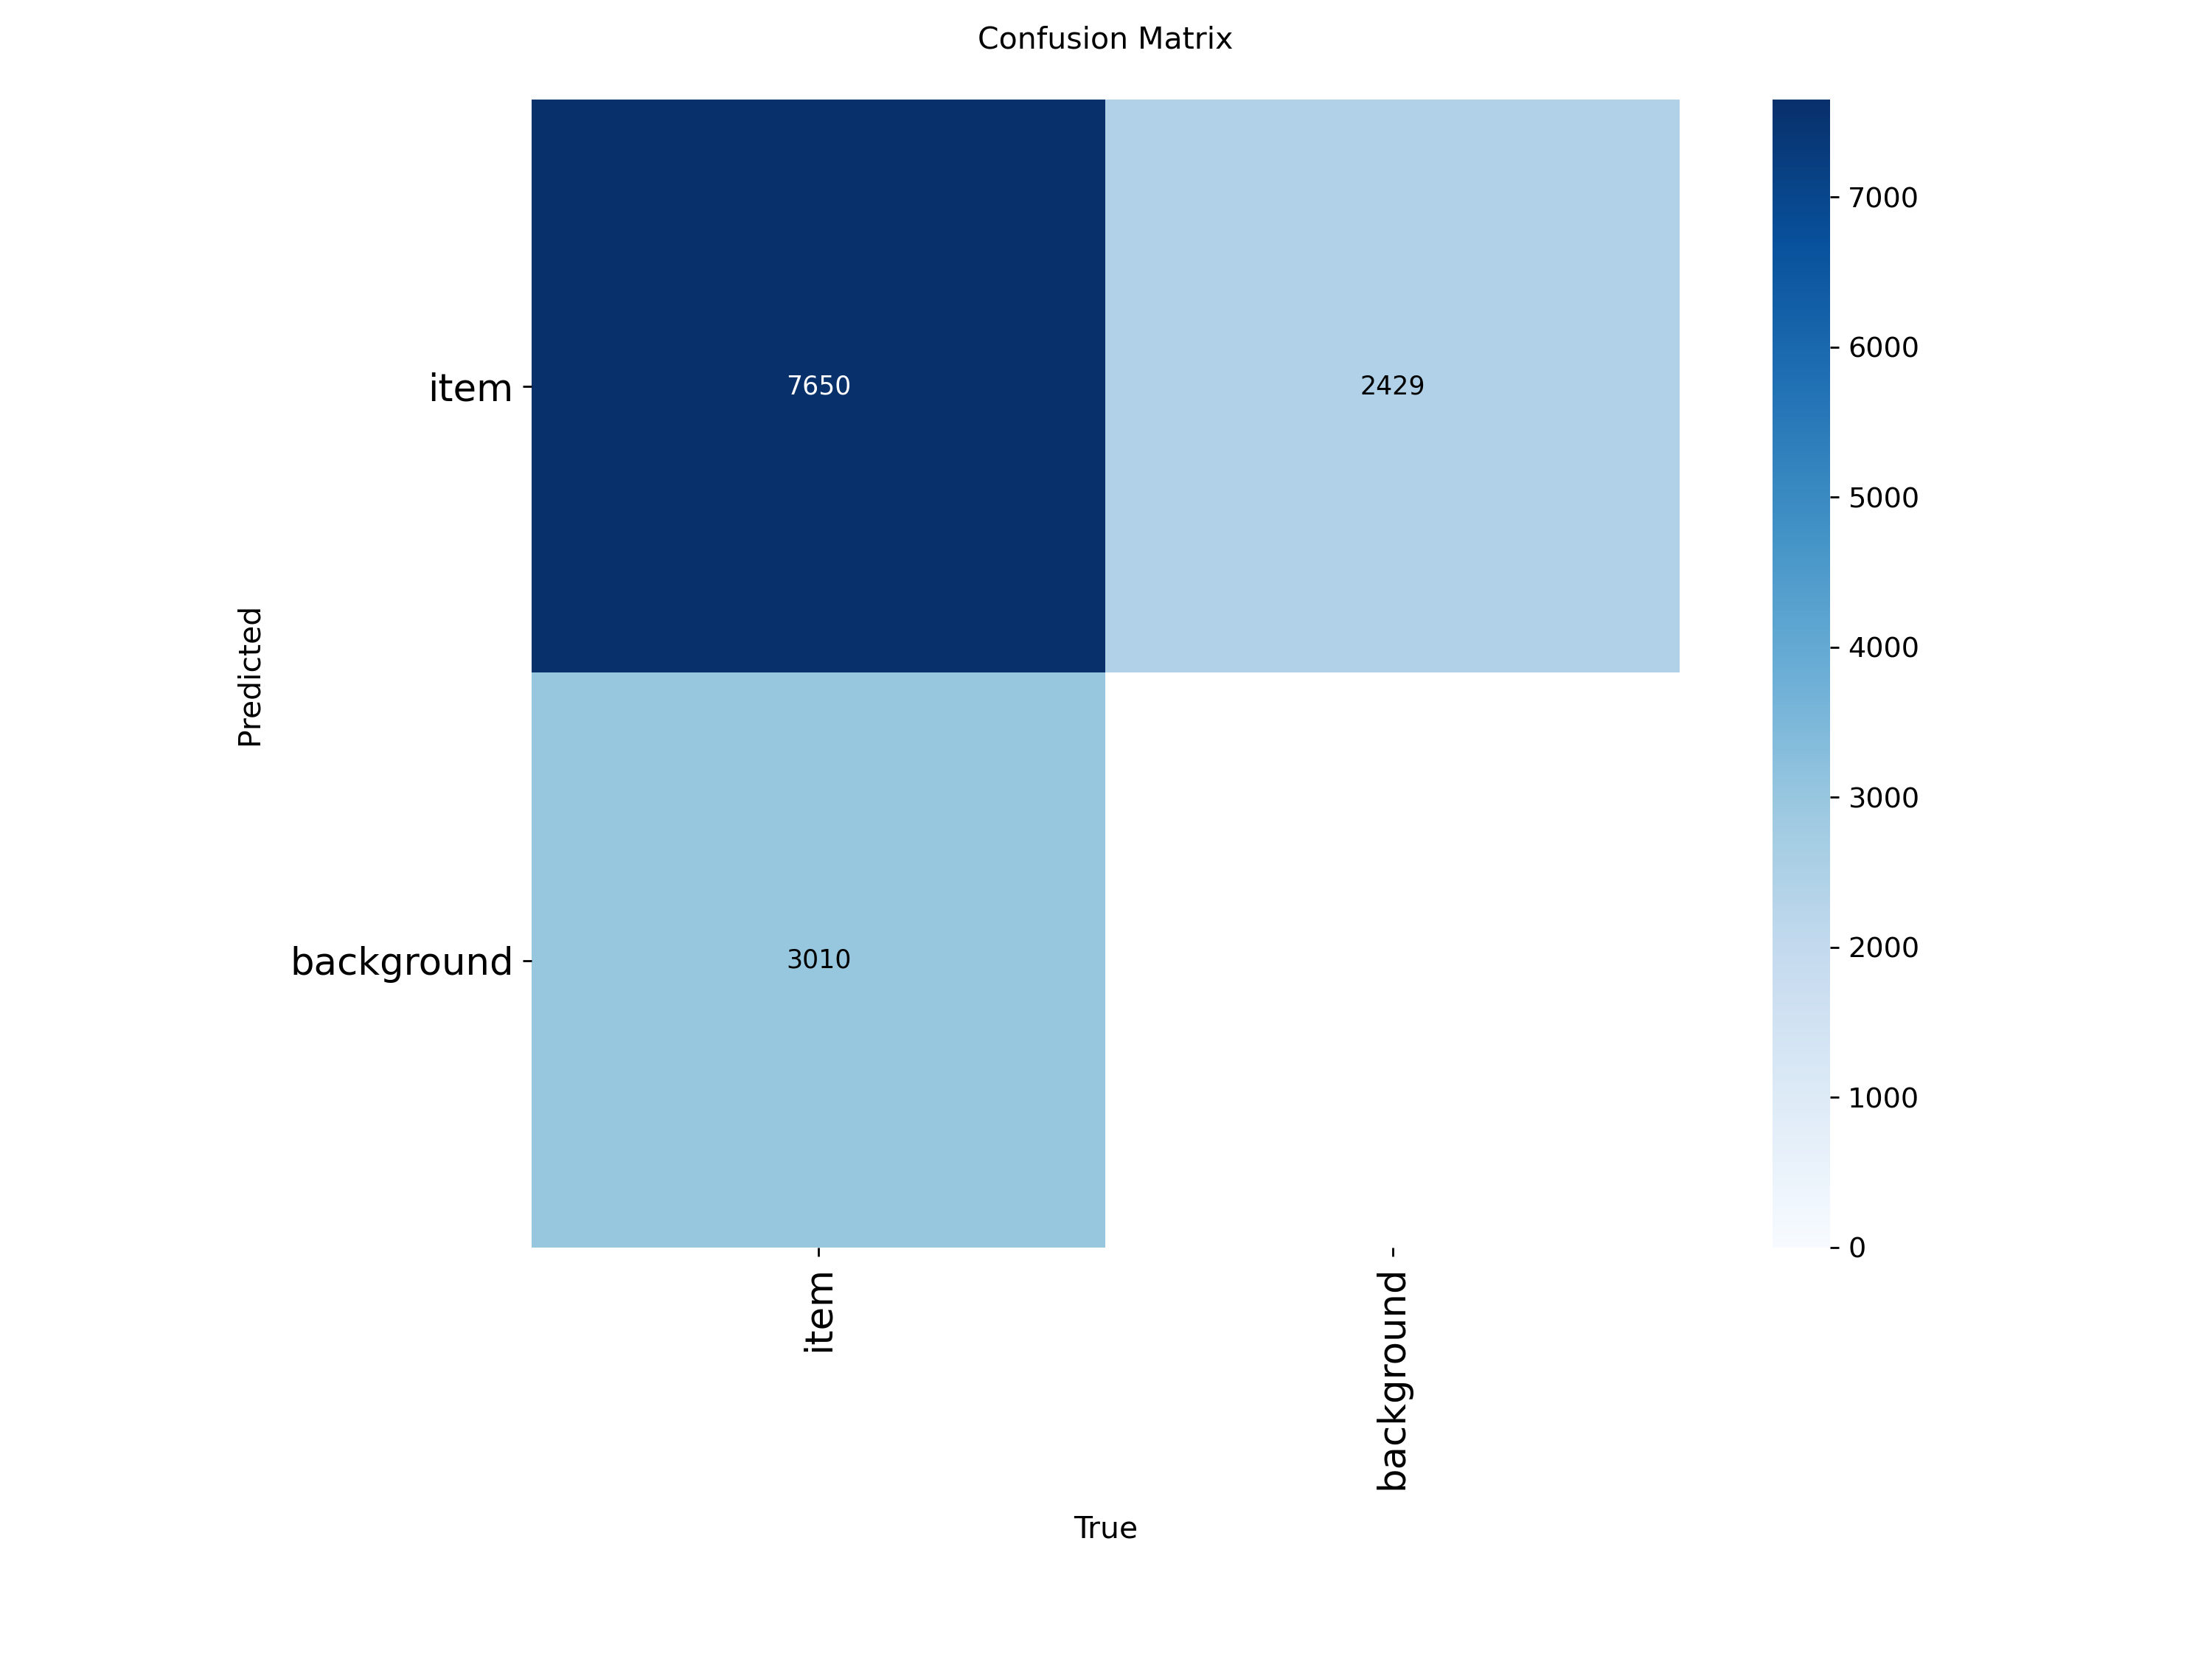


Displaying: results.png


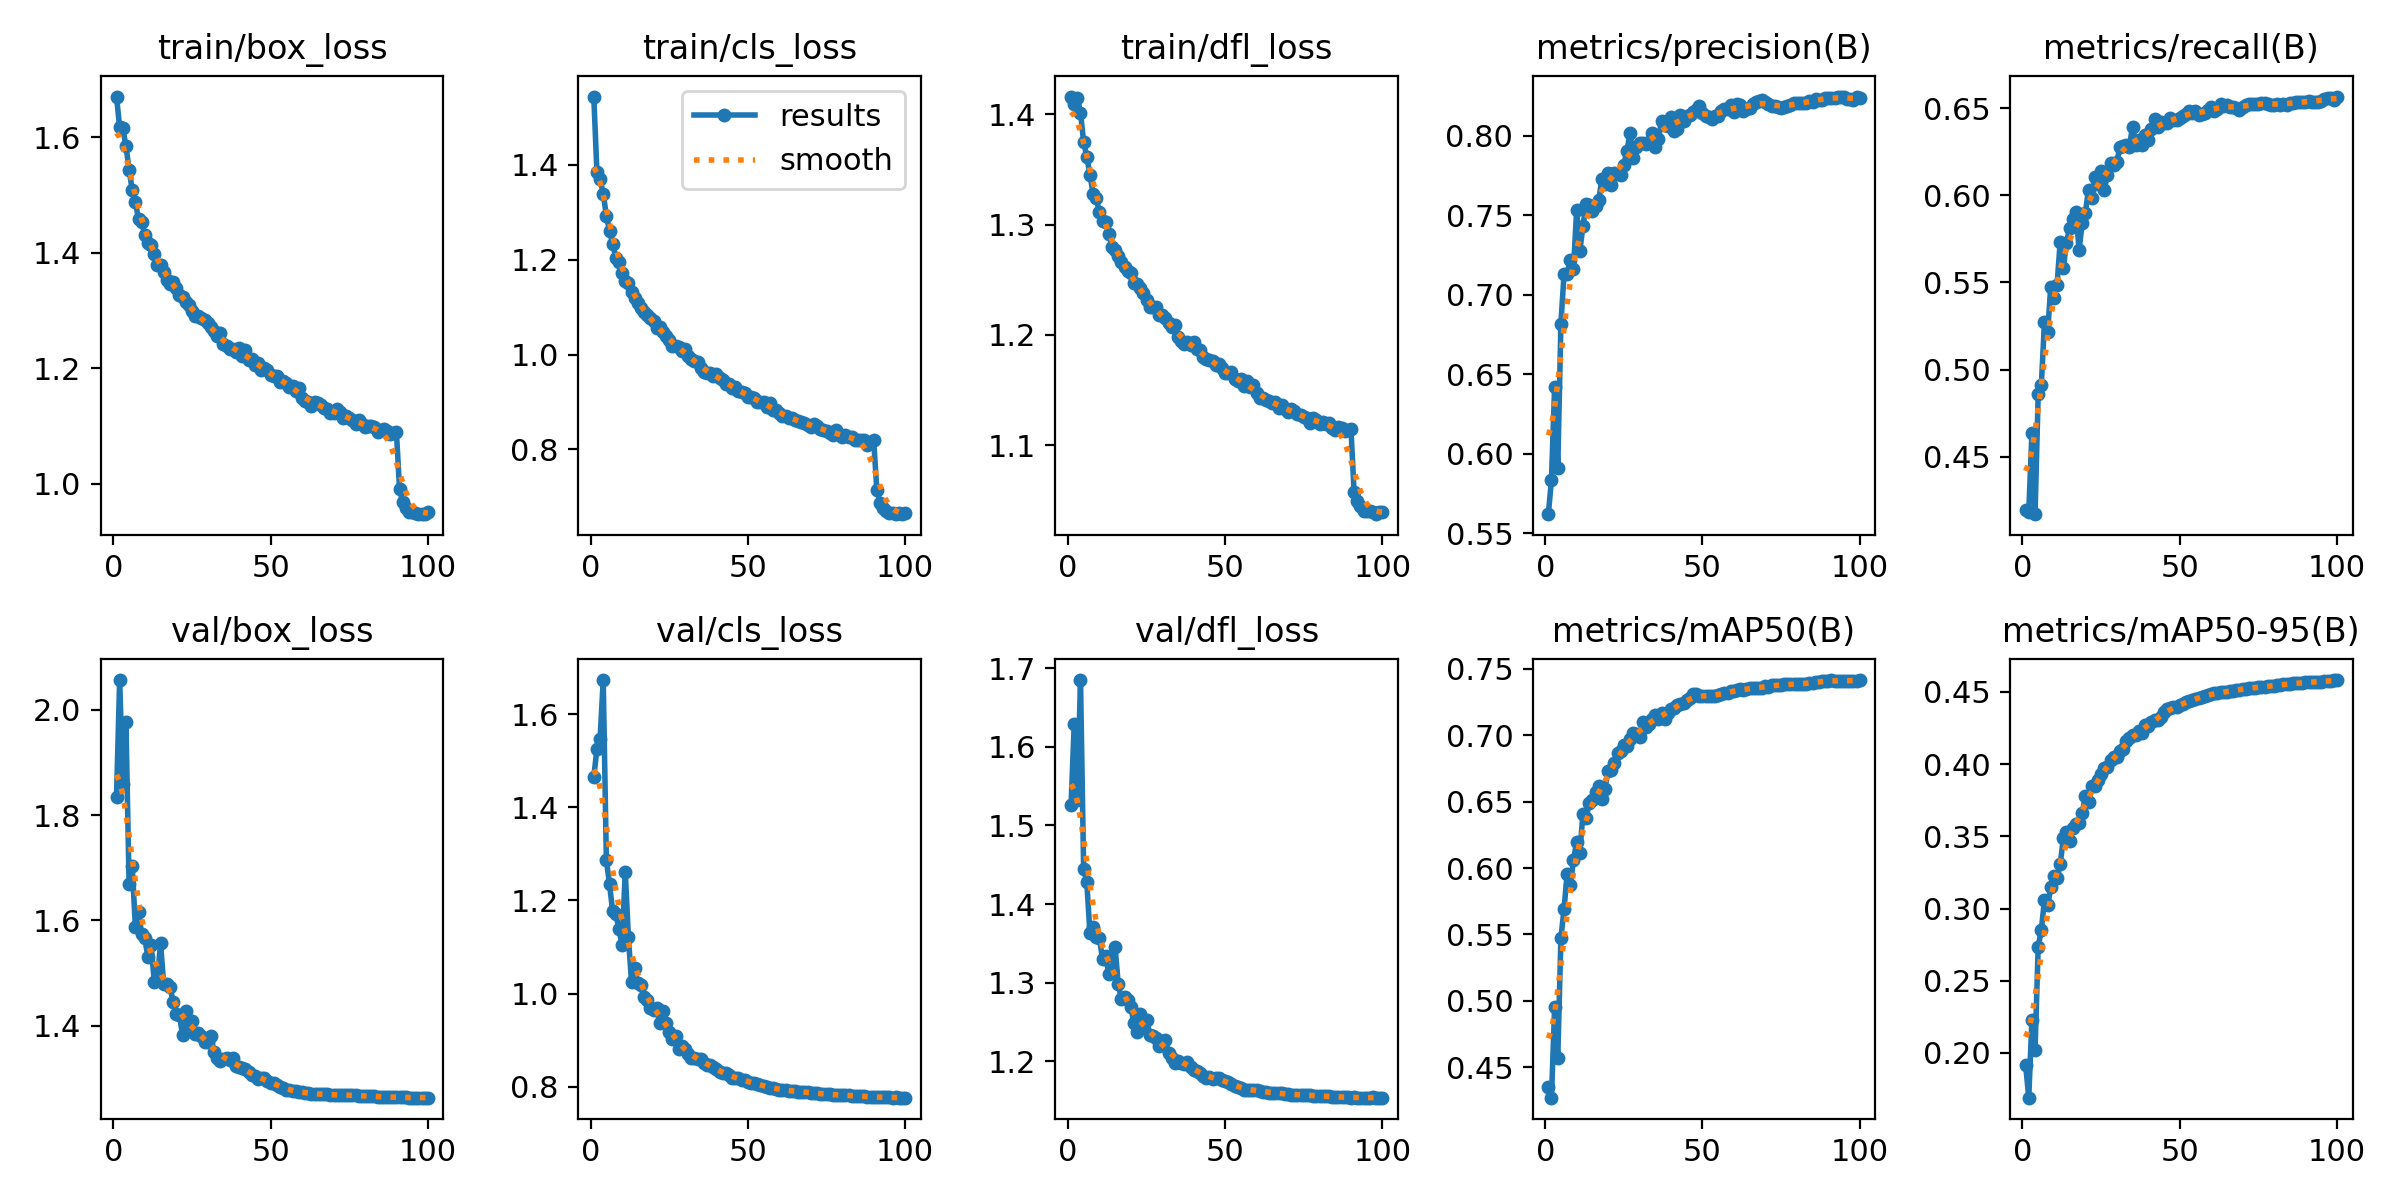


=== Testing on Sample Images ===

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1370 /content/datasets/people_detection_yolo/val/images/-1_-Av513706663-P1-_mp4-0_jpg.rf.75899bfbd97ba6ce3ec70fde16b16fa5.jpg: 384x640 15 items, 177.2ms
image 2/1370 /content/datasets/people_detection_yolo/val/images/-1_-Av513706663-P1-_mp4-13_jpg.rf.8267749fcacb971bbd911165ca193332.jpg: 384x640 2 items, 7.5ms
image 3/1370 /content/datasets/people_detection_yolo/val/images/-1_-Av513706663-P1-_mp4-15_jpg.rf.57eb

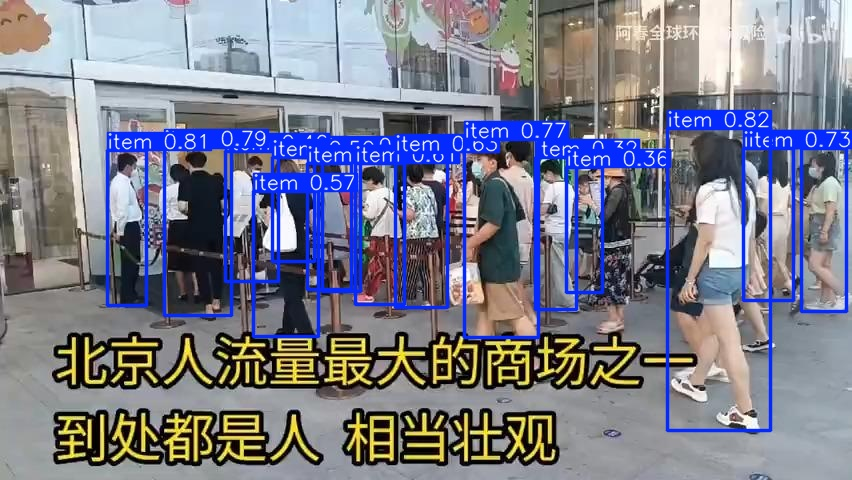


Prediction: -1_-Av513706663-P1-_mp4-13_jpg.rf.8267749fcacb971bbd911165ca193332.jpg


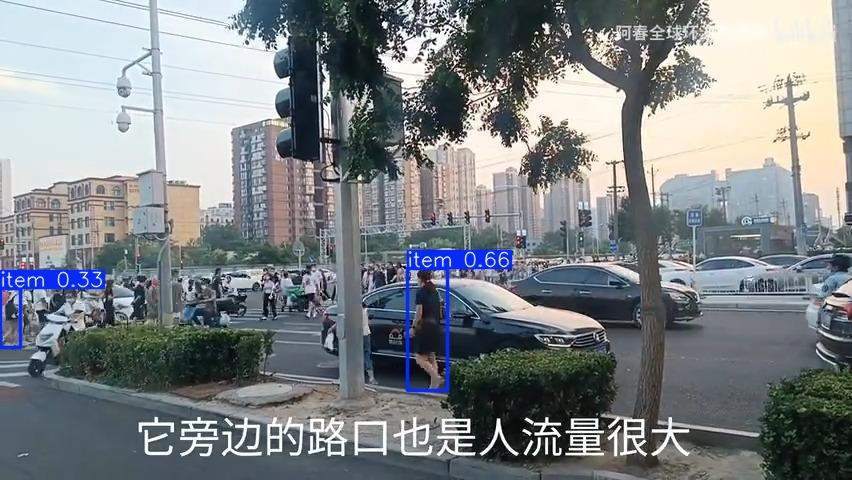


Prediction: -1_-Av513706663-P1-_mp4-15_jpg.rf.57ebf3ac6960bc954edf8e73e59426e0.jpg


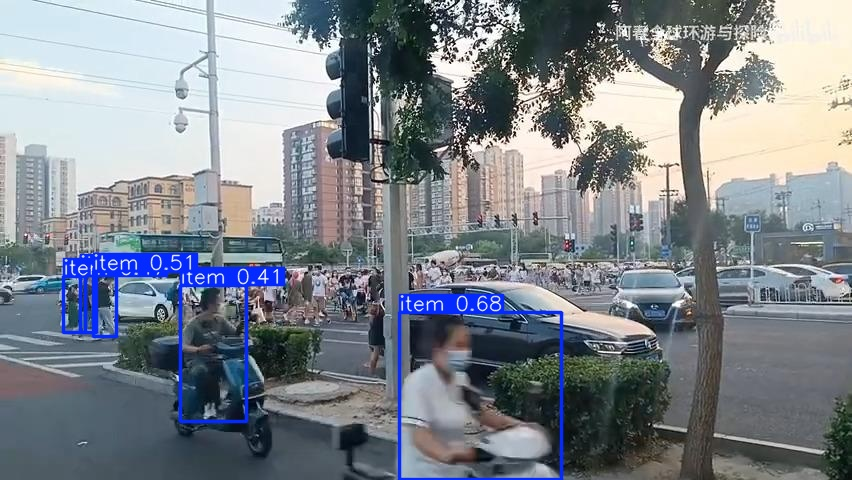


Prediction: -1_-Av513706663-P1-_mp4-16_jpg.rf.85ded751aaef2217abf21519d84dc67c.jpg


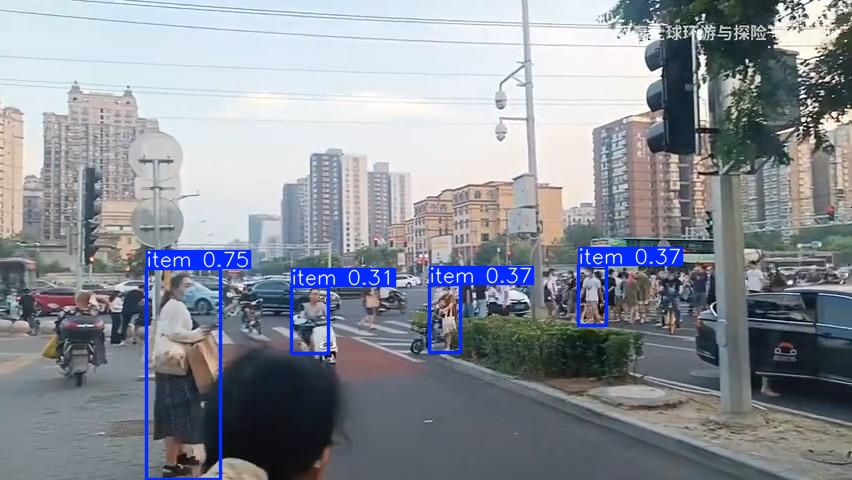


Prediction: -1_-Av513706663-P1-_mp4-18_jpg.rf.51efd03ddf8a74efad756315c8bd2992.jpg


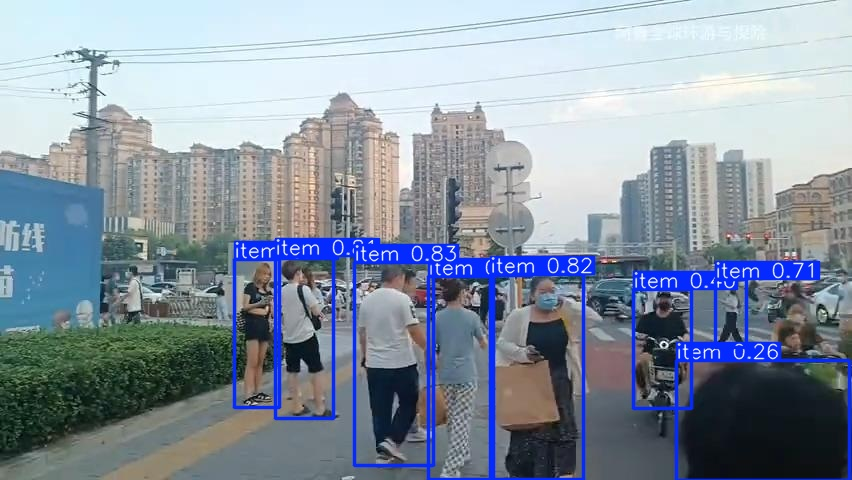

In [24]:
# Load the best model
best_model = YOLO('/content/results/face_detection_l4/weights/best.pt')

# 1. Show training results
results_path = '/content/results/face_detection_l4/results.csv'
if os.path.exists(results_path):
    import pandas as pd
    results_df = pd.read_csv(results_path)
    print("\n=== Training Results Summary ===")
    print(results_df.tail())  # Show last few epochs

    # Plot training curves
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot metrics
    metrics_to_plot = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss',
                      'val/box_loss', 'val/cls_loss', 'metrics/precision(B)']

    for ax, metric in zip(axes.flat, metrics_to_plot):
        if metric in results_df.columns:
            ax.plot(results_df['epoch'], results_df[metric])
            ax.set_title(metric)
            ax.set_xlabel('Epoch')
            ax.grid(True)

    plt.tight_layout()
    plt.show()

# 2. Show validation metrics
print("\n=== Validation Metrics ===")
metrics = best_model.val(
    data='/content/datasets/people_detection_yolo/data.yaml',
    split='val',
    batch=16,
    imgsz=640,
    device=device,
    plots=True,
    save_json=True,
    conf=0.001,
    iou=0.6
)

# Print key metrics
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP75: {metrics.box.map75:.4f}")
print(f"Precision: {metrics.box.p.item():.4f}")
print(f"Recall: {metrics.box.r.item():.4f}")

# 3. Show validation plots
print("\n=== Generated Plots ===")
plots_dir = '/content/results/face_detection_l4'
plot_files = ['confusion_matrix.png', 'F1_curve.png', 'P_curve.png',
              'R_curve.png', 'PR_curve.png', 'results.png']

# Import Image from IPython.display for displaying images from file paths
from IPython.display import Image as DisplayImage

for plot_file in plot_files:
    plot_path = os.path.join(plots_dir, plot_file)
    if os.path.exists(plot_path):
        print(f"\nDisplaying: {plot_file}")
        display(DisplayImage(filename=plot_path, width=600))

# 4. Test on sample images
print("\n=== Testing on Sample Images ===")
test_results = best_model.predict(
    source='/content/datasets/people_detection_yolo/val/images',  # Changed 'valid' to 'val'
    save=True,
    save_txt=True,
    save_conf=True,
    conf=0.25,
    iou=0.7,
    device=device,
    project='/content/results',
    name='predictions'
)

# Show some predictions
print(f"Generated {len(test_results)} predictions")
if len(test_results) > 0:
    # Display first few predictions
    prediction_dir = '/content/results/predictions'
    if os.path.exists(prediction_dir):
        pred_images = sorted(os.listdir(prediction_dir))[:5]
        for img_file in pred_images:
            if img_file.endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(prediction_dir, img_file)
                print(f"\nPrediction: {img_file}")
                display(DisplayImage(filename=img_path, width=400))


image 1/1 /content/datasets/people_detection/train/train/2010_003239_jpg.rf.cd89396c1f612ada4109c651bb8d6b70.jpg: 640x448 1 item, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /content/results/predictions
1341 labels saved to /content/results/predictions/labels


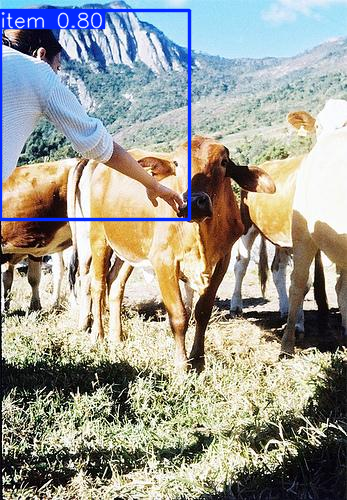


Detected 1 people
  Confidence: 0.80, BBox: [0.0, 10.21277904510498, 189.96810913085938, 219.42843627929688]


In [25]:
sample_image = train_images[0] if train_images else None
if sample_image:
    results = best_model(sample_image)

    # Plot results
    for result in results:
        result.show()  # Display image with predictions
        result.save(filename='/content/sample_prediction.jpg')  # Save prediction

    # Print predictions
    boxes = result.boxes
    print(f"\nDetected {len(boxes)} people")
    for box in boxes:
        print(f"  Confidence: {box.conf.item():.2f}, BBox: {box.xyxy[0].tolist()}")


## Export model for deployment

In [26]:
# Export to different formats
export_formats = ['onnx', 'torchscript', 'tflite', 'pb', 'saved_model']

for fmt in export_formats:
    try:
        best_model.export(format=fmt, imgsz=640, optimize=True, device='cpu') # Changed device from 0 to 'cpu'
        print(f"Exported to {fmt} format")
    except Exception as e:
        print(f"Failed to export to {fmt}: {str(e)}")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/results/face_detection_l4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 179ms
Prepared 6 packages in 4.41s
Installed 6 packages in 250ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 5.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.78.

## Save to Google Drive

In [27]:
!mkdir -p "/content/drive/MyDrive/YOLO_People_Detection"
!cp -r "/content/results/face_detection_l4" "/content/drive/MyDrive/YOLO_People_Detection/"
!cp "/content/results/face_detection_l4/weights/best.pt" "/content/drive/MyDrive/YOLO_People_Detection/best_model.pt"

print("Training completed! Model saved to Google Drive.")

Training completed! Model saved to Google Drive.


## Create a simple inference function


image 1/1 /content/datasets/people_detection/train/train/2010_003239_jpg.rf.cd89396c1f612ada4109c651bb8d6b70.jpg: 640x448 1 item, 44.3ms
Speed: 1.7ms preprocess, 44.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


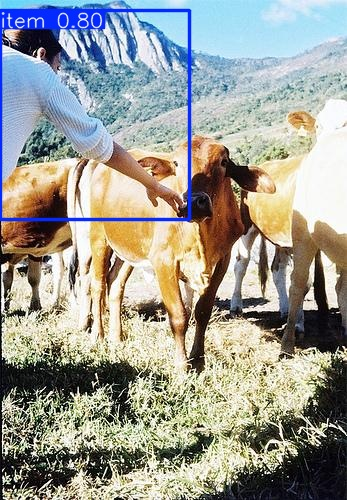

Detected 1 people


In [31]:
class PeopleDetector:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def detect(self, image_path, conf_threshold=0.25, iou_threshold=0.45):
        """
        Detect people in an image
        """
        results = self.model.predict(
            source=image_path,
            conf=conf_threshold,
            iou=iou_threshold,
            imgsz=640,
            device='cpu'
        )

        detections = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    detections.append({
                        'bbox': box.xyxy[0].tolist(),
                        'confidence': box.conf.item(),
                        'class': 'person'
                    })

        return detections, results[0].plot()  # Return detections and annotated image

# Test the detector
detector = PeopleDetector('/content/results/face_detection_l4/weights/best.pt')
detections, annotated_img = detector.detect(sample_image)

# Save annotated image
cv2.imwrite('/content/final_detection.jpg', annotated_img)
display(DisplayImage(filename='/content/final_detection.jpg', width=400))
print(f"Detected {len(detections)} people")